In [1]:
# Name: example_flash_current_dependence.ipynb
# Authors: Stephan Meighen-Berger
# Example how to check the possible pulse shape changes due to detector positioning and water currents.
# For a proper analysis we recommend to run the simulation with only a single organism type.
# The easiest way to set this up, is to define a custom organism in the life files with some absurd depth
# and then filter out anything above this depth

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import imageio
from tqdm import tqdm
import pickle

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [5]:
# picture path
PICS = '../pics/'

In [6]:
# Module imports
from fourth_day import Fourth_Day, config

In [7]:
# Some example settings
config['scenario']['population size'] = 100
config['scenario']['duration'] = 6000
config['scenario']['organism movement'] = False
config['scenario']['exclusion'] = True
config['scenario']['injection']['rate'] = 1
config['scenario']['injection']['y range'] = [0., 10.]
config['scenario']['light prop'] = {
            "switch": True,
            "x_pos": 5.,
            "y_pos": 10.,
        }
config['scenario']['detector'] = {
    "switch": True,
    "type": "PMTSpec",
    "response": True,
    "acceptance": "Flat",
    "mean detection prob": 0.5
}
# Organisms 
config['organisms']['emission fraction'] = 0.1
config['organisms']['alpha'] = 2.
config['organisms']['photon yield'] = 1e10
config["organisms"]["filter"] = 'depth'
config["organisms"]["depth filter"] = 100000  # Note the absurd depth. This is used to exclusively simulate custom organisms
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    "offset": np.array([0., 0.]),
}
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.15,
    "x_pos": 2.,
    "y_pos": 5.,
}
# Water
config['water']['model']['name'] = 'custom' # 'potential cylinder'
config['water']['model']['directory'] = "../data/current/long_run/"
config['water']['model']['time step'] = 0.1
config['advanced']['starting step'] = 0

In [8]:
# Which detectors we want to use for the analysis
wavelengths = {
    "Detector 1": ["1", "#4575b4"],
    "Detector 5": ["2", "#91bfdb"],
    "Detector 8": ["3", "#e0f3f8"],
    "Detector 3": ["4", "#fee090"],
    "Detector 10": ["5", "#fc8d59"],
}

In [9]:
# Launching multiple simulations to use in the analysis
seed = 1337
# General
config["general"]["random state seed"] = seed
# Creating a fourth_day object
fd = Fourth_Day()
# Launching solver
fd.sim()

In [18]:
# Fetching relevant data
# Totals
totals = fd.measured["Detector 1"].values
for detector in wavelengths.keys():
    if detector == "Detector 1":
        continue
    fd.measured[detector].values
    totals += fd.measured[detector].values

In [19]:
# Pre-processing results
# Depending on the setup these values do need to be changed
totals = totals  # The simulation has a "warm-up" phase. This depends on the water current. One cycle is recommended
totals[totals < 0] = 0  # Depending on the setup the cut-off needs to be lowered or increased

In [20]:
# Smoothing function for plotting
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [21]:
# Plotting standards
std_size = 3.
fontsize = 10.
lw=1.
h_length=0.2

In [105]:
# Searching for peaks
from itertools import groupby
peaks = [list(v) for k,v in groupby(totals, key = lambda x: x != 0) if k != 0]
number_of_peaks = len(peaks)
peak_order = np.arange(len(peaks))

In [106]:
number_of_peaks

16

In [109]:
del peaks[9]

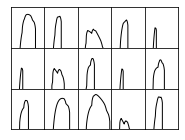

In [159]:
# The appearing pulse shapes
figure, axsarr = plt.subplots(3, 5, figsize=(std_size, std_size * 6. / 8.))
axsarr = axsarr.ravel()
for peak_id, peak in enumerate(peaks):
    peak.insert(0, 0.)
    peak.append(0.)
    axsarr[peak_id].plot(np.arange(len(peak)) * 0.1 + 1.,
             smooth(peak, 5),
             lw=lw, color='k')
    axsarr[peak_id].set_xscale('linear')
    axsarr[peak_id].set_yscale('log')
    # ax1.set_xlabel(r'$\mathrm{t}\;[\mathrm{s}]$', fontsize=fontsize)
    # ax1.set_ylabel(r'$\mathrm{Photons}$', fontsize=fontsize)
    # axsarr[peak_id].tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
    # axsarr[peak_id].tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
    # ax1.grid(True)
    # Removing ticks
    axsarr[peak_id].set_xticks([])
    axsarr[peak_id].set_xticks([], minor=True)
    axsarr[peak_id].set_yticks([])
    axsarr[peak_id].set_yticks([], minor=True)
    axsarr[peak_id].set_ylim(1e3,1e8)
    axsarr[peak_id].set_xlim(0., 10.)
    axsarr[peak_id].set_xticklabels([])
    axsarr[peak_id].set_yticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
plt.show()
figure.savefig(PICS + "MC_Peak_Spread.pdf",
               bbox_inches='tight')

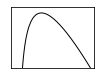

In [160]:
# The original pulse shape
mean = fd.statistics[-1]["pulse mean"].values[0] * 0.1
sd = fd.statistics[-1]["pulse sd"].values[0] * 0.1
from fourth_day.pdfs import construct_pdf
pdf = construct_pdf({
    "class": config['organisms']['pdf pulse']['pdf'],
    "mean": mean,
    "sd": sd
})
x_grid = np.linspace(0., 100, 1000)
# The appearing pulse shapes
smaller_standard = std_size / 2.
figure, axsarr = plt.subplots(1, 1, figsize=(smaller_standard, smaller_standard * 6. / 8.))
axsarr.plot(
    x_grid + 1.,
    pdf.pdf(x_grid) * 1e10,
    lw=lw, color='k')
axsarr.set_xscale('linear')
axsarr.set_yscale('log')
# ax1.set_xlabel(r'$\mathrm{t}\;[\mathrm{s}]$', fontsize=fontsize)
# ax1.set_ylabel(r'$\mathrm{Photons}$', fontsize=fontsize)
# axsarr[peak_id].tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
# axsarr[peak_id].tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
# Removing ticks
axsarr.set_xticks([])
axsarr.set_xticks([], minor=True)
axsarr.set_yticks([])
axsarr.set_yticks([], minor=True)
axsarr.set_ylim(1e6,1e10)
axsarr.set_xlim(0., 10.)
axsarr.set_xticklabels([])
axsarr.set_yticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
plt.show()
figure.savefig(PICS + "MC_Peak_Org.pdf",
               bbox_inches='tight')